<a href="https://colab.research.google.com/github/SaharaAli16/spatiotemporal-causality/blob/main/stcausal2024/hands-on-demo/Causal_Inference_Spatiotemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Effect Estimation using Spatiotemporal Data

In this notebook, we will see how can we estimate the causal effect from spatiotemporal data.

Here are the steps that will be involved in this notebook.
1. Load necessary libraries
3. Generate synthetic data set
4. Causal effect estimation and analysis


Source: https://github.com/iharp-institute/causality-for-arctic-amplification/tree/main/stcinet

## 1. Initial Setup

In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import scipy.ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Input
from tensorflow.keras.layers import Add, Lambda, Multiply, Activation, Dense, Dropout, Conv2D, ConvLSTM2D, Conv2DTranspose, BatchNormalization, UpSampling2D,MaxPooling2D, concatenate, Flatten, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model, Model

In [ ]:
from numpy.random import seed
seed(1)

## 2. Synthetic Data Generation
We are going to generate three spatiotemporal variables 𝐴, 𝐵 and 𝐶 adapting the data-generation process of STCINet based on diffusion (Ali et.al, ECML 2024).

Diffusion is a physical process that describes the movement of particles
or substances from regions of higher concentration to regions
of lower concentration. It is driven by the random motion of particles,
and it tends to equalize the concentration of substances in a given medium over time.

In [2]:
# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 4000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    #Intervention on a sub-region of B
    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)))

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)))

a = variable_a.reshape(4000, 28, 28, 1)
b = variable_b.reshape(4000, 28, 28, 1)
c = variable_c.reshape(4000, 28, 28, 1)
c_cf = variable_c_cf.reshape(4000, 28, 28, 1)
data = np.concatenate([a, b, c, c_cf], 3)

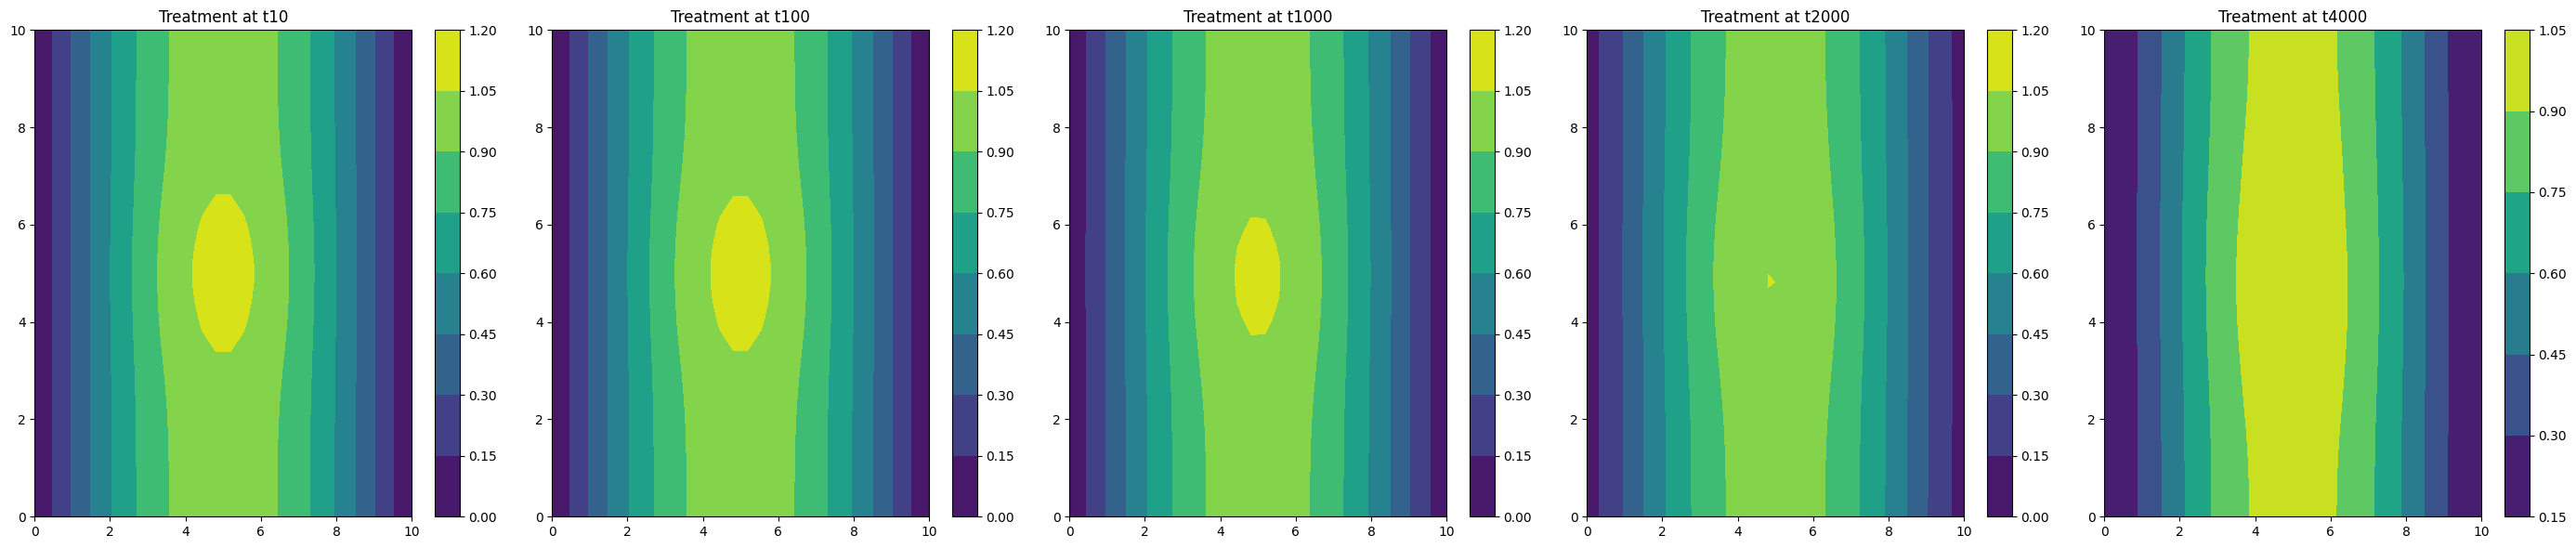

In [3]:
# Plotting the pre-intervened treatment variable
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_b[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_b[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_b[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_b[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_b[3999, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t4000')

plt.tight_layout()
plt.show()

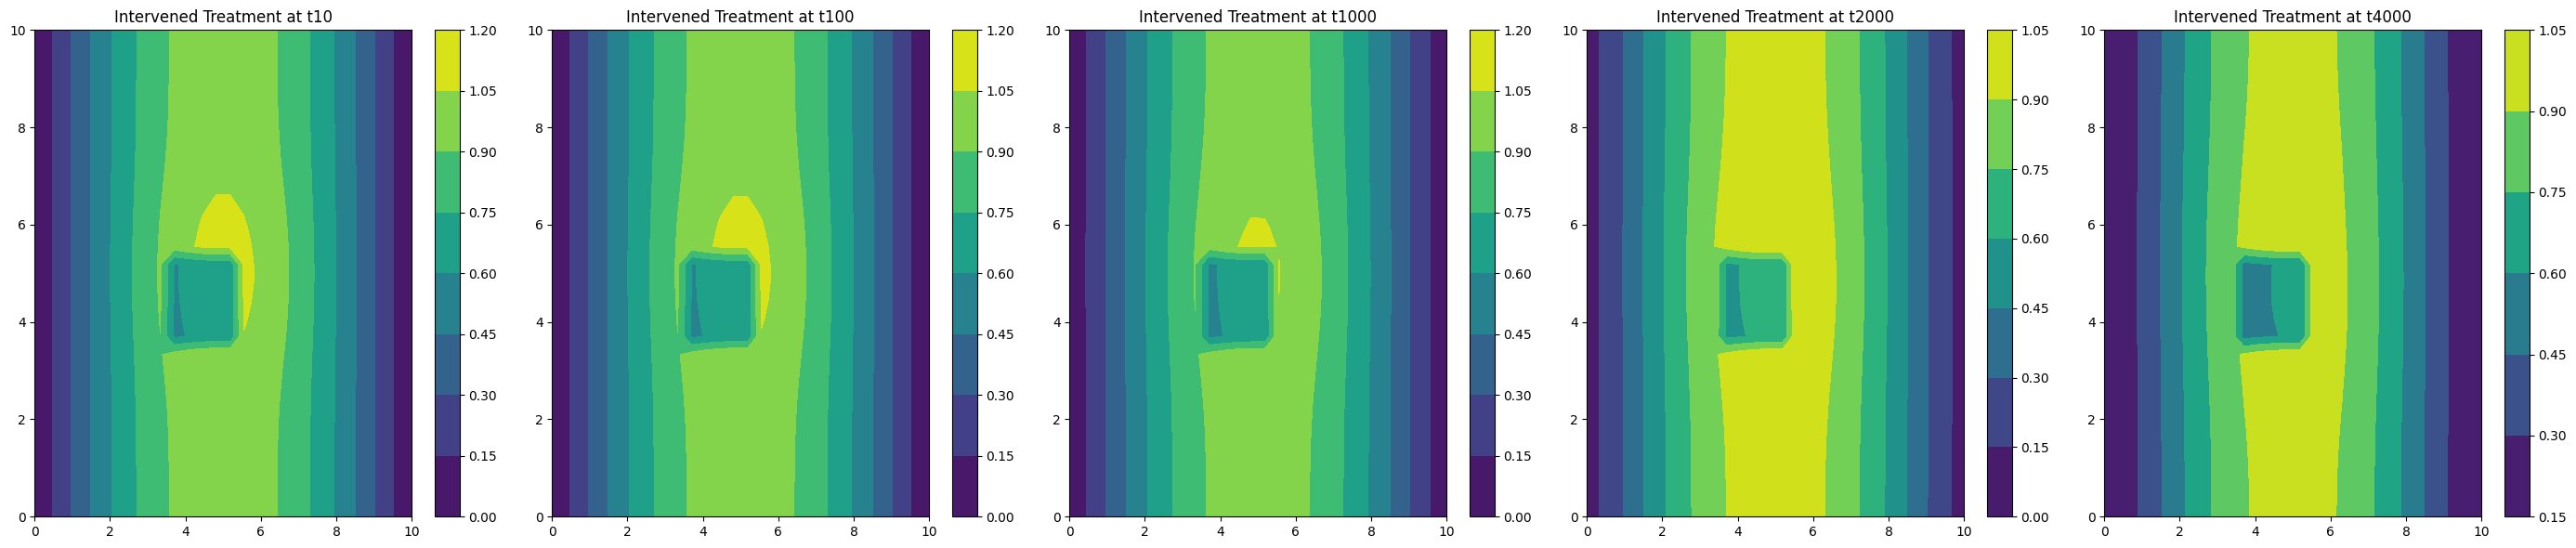

In [4]:
# Plotting the post-intervened treatment variable
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_b_cf[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_b_cf[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_b_cf[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_b_cf[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_b_cf[3999, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t4000')

plt.tight_layout()
plt.show()

## 3a. Data Preprocessing

In [5]:
#3.1 Splitting the data into covariates, treatment and target variables
data = data[:,:,:,:]
cov = data[:,:,:,:-2]
cf_data = data[:,:,:,-1]
target = data[:,:,:,-2]
data = data[:,:,:,:-1]

#3.2 Adding a lag to target
lag = 1

data = data[lag:-lag,:,:,:]
target = target[lag+1:,:,:]
cf_data = cf_data[lag+1:,:,:]
cov = cov[:-(lag+1),:,:]

#3.3 Shifting treatment to last column
tr = data[:,:,:,-2].copy()
tr = tr.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(tr.shape)
print(data.shape)
data = np.delete(data, -2, 3)
print(data.shape)
data = np.concatenate([data, tr], 3)
print(data.shape)

#3.4 Creating train:test sets
x_train = data[:,:,:,:]
x_test = data[:,:,:,:]

#3.5 Create input2 of treatment and covariate history
x_train2 = cov[:,:,:,:]
x_test2 = cov[:,:,:,:]
y_train=target[:,:,:]
y_test=target[:,:,:]

#3.6 Replacing all nans with Zeros
x_train = np.nan_to_num(x_train)
x_train2 = np.nan_to_num(x_train2)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
x_test2 = np.nan_to_num(x_test2)
y_test = np.nan_to_num(y_test)

#3.7 Applying treatment to selective region
x_treated = np.copy(x_test)
x_treated[:,10:15,10:15,-1] = x_treated[:,10:15,10:15,-1]*(0.6)

(3998, 28, 28, 1)
(3998, 28, 28, 3)
(3998, 28, 28, 2)
(3998, 28, 28, 3)


##3b Normalization and Reshaping

In [6]:
# Standard Scaling to normalize data

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[-1])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[-1])) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,x_treated.shape[-1])) #reshaping to 2d for standard scaling

scaler_h = StandardScaler()
x_train2 = scaler_h.fit_transform(x_train2.reshape(-1,x_train2.shape[-1])) #reshaping to 2d for standard scaling
x_test2 = scaler_h.transform(x_test2.reshape(-1,x_test2.shape[-1])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling

In [7]:
#Reshaping data to 3D for modeling

lat = 28
lon = 28
features = 3
features2 = 2
timestep = 1
LEN_DATA = 3998

def reshape_features(dataset, samples, timestep, lat, lon, features):
    print(dataset.shape)
    X = dataset.reshape(samples, timestep, lat, lon, features)
    return X

def reshape_outcome(dataset, timestep, lat, lon):
    print(dataset.shape)
    X = dataset.reshape(timestep, lat, lon, 1)
    return X

x_train = reshape_features(x_train, LEN_DATA, timestep, lat, lon, features) # reshaping to 3d for model
x_test = reshape_features(x_test, LEN_DATA, timestep, lat, lon, features) # reshaping to 3d for model
x_treated = reshape_features(x_treated, LEN_DATA, timestep, lat, lon, features) #reshaping to 2d for standard scaling

x_train2 = reshape_features(x_train2, LEN_DATA, timestep, lat, lon, features2) # reshaping to 3d for model
x_test2 = reshape_features(x_test2, LEN_DATA, timestep, lat, lon, features2) # reshaping to 3d for model

y_train = reshape_outcome(y_train, LEN_DATA, lat, lon) # reshaping to 3d for model
y_test = reshape_outcome(y_test, LEN_DATA, lat, lon) # reshaping to 3d for model

(3134432, 3)
(3134432, 3)
(3134432, 3)
(3134432, 2)
(3134432, 2)
(3134432, 1)
(3134432, 1)


##4. Building the Model

In [8]:
#4.1 Setting Model Parameters
lat = 28
lon = 28
features2 = 3 #actual features
features = 2 #history
timestep = 1

input1_shape = (timestep, lat, lon, features)
input2_shape = (timestep, lat, lon, features2)

filter_size=3
use_temp_scaling=False
n_output_classes=1
metrics = RootMeanSquaredError()
loss = tf.keras.losses.MeanSquaredError()
print(input1_shape, input2_shape)

(1, 28, 28, 2) (1, 28, 28, 3)


In [9]:
#4.2 Designing Deep Learning pipeline

input1 = Input(shape=input1_shape)
input2 = Input(shape=input2_shape)

convlstm2 = ConvLSTM2D(8, (5,5), padding="same", return_sequences=False, data_format="channels_last")(input2)
print('K.int_shape(convlstm2)',K.int_shape(convlstm2))

    #UNet-----start-----------
conv1 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(convlstm2)
conv1 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
bn1 = BatchNormalization(axis=-1)(conv1)
print('K.int_shape(bn1)',K.int_shape(bn1))
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
bn2 = BatchNormalization(axis=-1)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = Conv2D(256, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
bn3 = BatchNormalization(axis=-1)(conv3)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn3))
merge8 = concatenate([up8, bn2], axis=3)
conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
bn8 = BatchNormalization(axis=-1)(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn8))
merge9 = concatenate([up9, bn1], axis=3)
conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    #UNet-----end-----------

output = Conv2D(n_output_classes, 1, activation='linear', name="unet_output")(conv9)

model = Model(inputs = input2, outputs = output)
model.compile(optimizer=Adam(), loss=loss, metrics = [metrics])

K.int_shape(convlstm2) (None, 28, 28, 8)
K.int_shape(bn1) (None, 28, 28, 64)


In [10]:
#4.3 Fitting the model
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=x_train, y=y_train,epochs=10,batch_size=64,callbacks = [callback],validation_split=.2,verbose = 2)


Epoch 1/10
50/50 - 31s - 629ms/step - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 1.5021 - val_root_mean_squared_error: 1.2256 - learning_rate: 0.0010
Epoch 2/10
50/50 - 21s - 414ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 1.5101 - val_root_mean_squared_error: 1.2289 - learning_rate: 0.0010
Epoch 3/10
50/50 - 2s - 49ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 1.4621 - val_root_mean_squared_error: 1.2092 - learning_rate: 0.0010
Epoch 4/10
50/50 - 2s - 44ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 1.3772 - val_root_mean_squared_error: 1.1736 - learning_rate: 0.0010
Epoch 5/10
50/50 - 3s - 51ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 1.0375 - val_root_mean_squared_error: 1.0186 - learning_rate: 0.0010
Epoch 6/10
50/50 - 3s - 54ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.8139 - val_root_mean_squared_error: 0.9022 - learning_rate: 0.0010
Epoch 7/10
5

## Causal Effect Estimation

In [11]:
y_pred = model.predict(x_test)
y_pred_cf = model.predict(x_treated)

# invert scaling for forecasted values
inv_y_pred = scaler_l.inverse_transform(y_pred.reshape(-1,1))
inv_y_pred_cf = scaler_l.inverse_transform(y_pred_cf.reshape(-1,1))

# invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test.reshape(-1,1))

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test.flatten(), inv_y_pred.flatten()))
print('Test RMSE: %.3f' % rmse)

rmse1 = sqrt(mean_squared_error(cf_data.flatten(), inv_y_pred_cf.flatten()))
print('Treated RMSE: %.3f' % rmse1)

Test RMSE: 0.746
Treated RMSE: 0.707


In [13]:
#ATE
pred_ate = inv_y_pred_cf - inv_y_pred
mean_pred_ate = np.mean(pred_ate,axis=0)
print('Mean ATE:',np.mean(mean_pred_ate))

Mean ATE: -0.013047076


In [14]:
inv_y_pred = inv_y_pred.reshape(len(y_pred),28, 28)
print(inv_y_pred.shape)
inv_y_pred_cf = inv_y_pred_cf.reshape(len(y_pred_cf),28, 28)
print(inv_y_pred_cf.shape)
inv_y_test = inv_y_test.reshape(len(y_test),28, 28)
print(inv_y_pred.shape)

(3998, 28, 28)
(3998, 28, 28)
(3998, 28, 28)


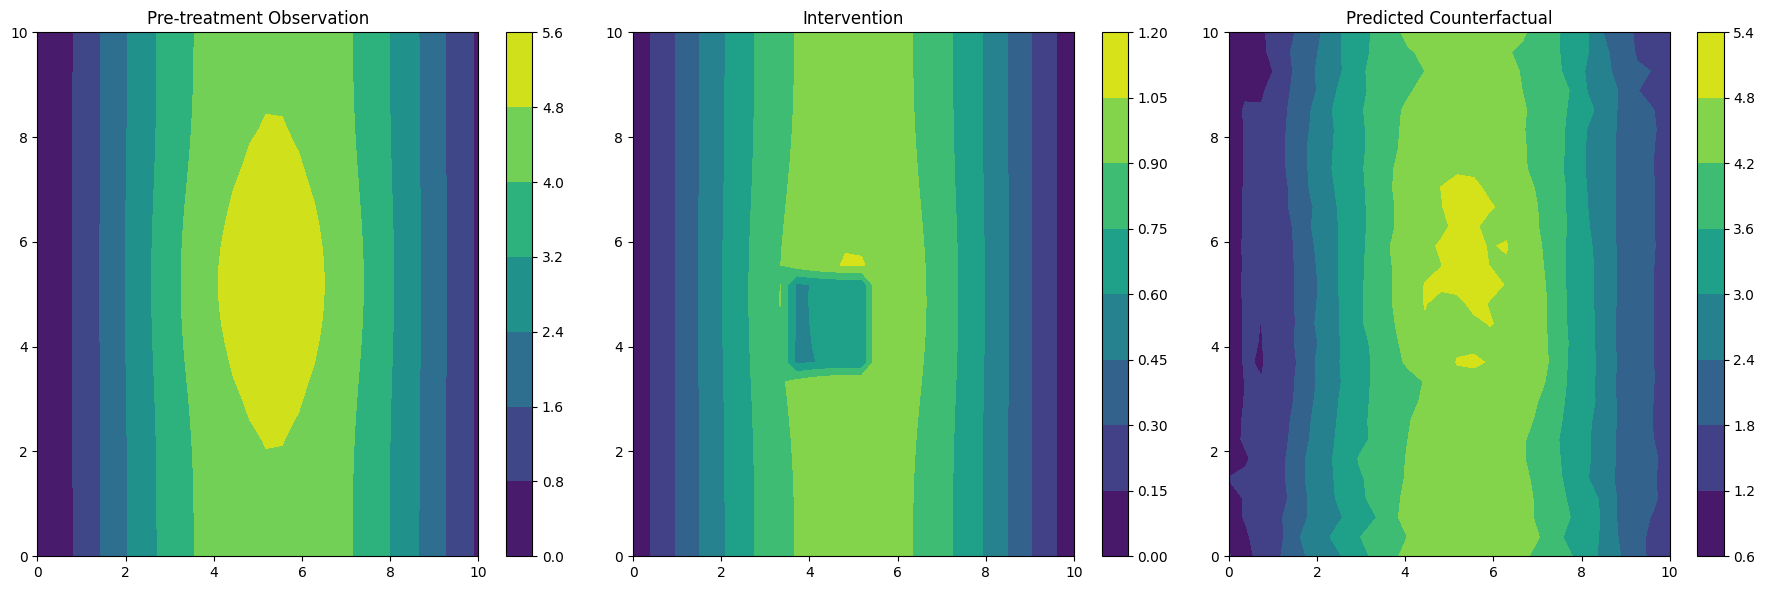

In [18]:
# Plotting the final state of the variables
# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, inv_y_test[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Pre-treatment Observation')


plt.subplot(1, 3, 2)
plt.contourf(X, Y, variable_b_cf[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervention')

plt.subplot(1, 3, 3)
plt.contourf(X, Y, inv_y_pred_cf[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Predicted Counterfactual')

plt.tight_layout()
plt.show()